# Exploring `xarray`

In [1]:
import os

import cartopy

import datetime as dt
import h5py as h5
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path as path
from matplotlib import pyplot as plt

In [12]:
# create variables holding paths to input data
DATA_DIR = os.path.join('..', 'data')
INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
SMAP_DATA_DIR = os.path.join(INPUT_DATA_DIR, 'SMAP', 'SPL3SMP.005')

# file suffix pattern for the SMAP files of interest
SMAP_FILE_SUFFIX = '*_R16010_001.h5'

# get paths to all HDF5 files ending with SMAP_FILE_SUFFIX
# found in all directories within SMAP_DATA_DIR
DATA_PATHS = sorted([str(filepath) for filepath in path(SMAP_DATA_DIR).rglob(SMAP_FILE_SUFFIX)])

# get the first in path DATA_PATHS to use for testing
TEST_DATA_PATH = DATA_PATHS[0]

# the HDF5 files contain many datasets, but
# the soil_moisture dataset is what we're interested in
AM_DATASET_NAME = 'Soil_Moisture_Retrieval_Data_AM'
PM_DATASET_NAME = 'Soil_Moisture_Retrieval_Data_PM'
SM_DATASET_NAME = 'soil_moisture'
PM_SM_DATASET_NAME = 'soil_moisture_pm'

# create variables to hold path to files containing EASE grid lat/lons (used for plotting)
# data source: https://github.com/TUW-GEO/ease_grid/tree/master/tests/test_data
EASE_GRID_DIR = os.path.join(DATA_DIR, 'ease_grid')
EASE_LATS_PATH = os.path.join(EASE_GRID_DIR, 'EASE2_M36KM.lats.964x406x1.double')
EASE_LONS_PATH = os.path.join(EASE_GRID_DIR, 'EASE2_M36KM.lons.964x406x1.double')

# store the EPSG projection code for the EASE Grid
# that this data uses (not used in this notebook)
EASE_CRS = 'epsg:6933'

# create a path to an output directory in case
# we want to save files at some point
OUTPUT_DIR = os.path.join(DATA_DIR, 'output')

# check if OUTPUT_DIR exists and, if not, create it
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    
FIG_SIZE = (30, 10)

In [13]:
# read EASE2 lat/lons and then reshape from a 1D to 2D array matching the EASE Grid shape (EASE_SHAPE)
EASE_SHAPE = (406, 964)
EASE_LATS = np.fromfile(EASE_LATS_PATH, dtype=np.float64).reshape(EASE_SHAPE)
EASE_LONS = np.fromfile(EASE_LONS_PATH, dtype=np.float64).reshape(EASE_SHAPE)

In [14]:
def print_dataset_names(src_path: str):
    '''
    Print name of datasets in file at src_path.
    '''
    
    print(f'Datasets contained in: {src_path}', end='\n\n')
    
    # open file at src_path with rasterio
    with h5.File(src_path, 'r') as src:
        for subdataset in src.keys():
            print(subdataset)
            for dataset in src.get(subdataset).keys():
                print(" |--", dataset)

In [15]:
def parse_date(src_path: str):
    
    date_str = src_path.split('_')[4]
    date = dt.datetime.strptime(date_str, '%Y%m%d')
    
    return date

In [16]:
def read_dataset(src_path: str, target_dataset: str, target_subdataset: str, mask_nodata: bool = True):
    '''
    Read dataset_name in HDF5 file at src_path.
    '''
                
    data = xr.open_dataset(src_path, group=target_dataset, mask_and_scale=mask_nodata)[target_subdataset]

    data.attrs['crs'] = EASE_CRS
    data.attrs['time'] = parse_date(src_path)
    
    data = data.rename({'phony_dim_0': 'y',
                   'phony_dim_1': 'x'})
    
    return data.assign_coords({'y': EASE_LATS[:,0],
                      'x': EASE_LONS[0]})

In [17]:
read_dataset(TEST_DATA_PATH, AM_DATASET_NAME, SM_DATASET_NAME)

<xarray.DataArray 'soil_moisture' (y: 406, x: 964)>
[391384 values with dtype=float32]
Coordinates:
  * y        (y) float64 83.63 81.48 79.77 78.3 ... -78.3 -79.77 -81.48 -83.63
  * x        (x) float64 -179.8 -179.4 -179.1 -178.7 ... 178.7 179.1 179.4 179.8
Attributes:
    long_name:    Representative soil moisture measurement for the Earth base...
    units:        cm**3/cm**3
    coordinates:  /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Re...
    valid_min:    0.02
    valid_max:    0.5
    crs:          epsg:6933
    time:         2017-03-01 00:00:00

In [8]:
def stack_datasets(data_paths: list, target_dataset: str, target_subdataset: str, mask_nodata: bool = True):
    '''
    Read in 2d arrays and stack as 3d arrays.
    '''

    # create some empty variables that we'll add to
    dataset = []
    times = []
    
    # loop over the paths to each file
    for i, data_path in enumerate(data_paths, 0):
        
        # read each dataset
        data_i = read_dataset(data_path, target_dataset, target_subdataset, mask_nodata)
        
        dataset.append(data_i)
        times.append(data_i.attrs['time'])
    
    return xr.concat(dataset, dim='time').assign_coords({'time': times})

In [9]:
def calc_mean(data_stack: xr.Dataset, dim: str='time'):
    return data_stack.mean(dim=dim, keep_attrs=True)

In [10]:
def plot_data(data: xr.DataArray, projection: str = 'cyl',
              extent: list = None, cmap: str = 'viridis_r'):

    '''
    Plot data.
    '''
    
    # define the plot size and create an axis object (ax) to plot on
    fig, ax = plt.subplots(figsize=FIG_SIZE, subplot_kw={'projection': cartopy.crs.PlateCarree()})
    
    # want to zoom in? set the extent of the plot
    if extent:
        ax.set_extent(extent)

    # plot the actual data!
    plot = data.plot(vmin=sm_timeseries.attrs['valid_min'],
                     vmax=sm_timeseries.attrs['valid_max'],
                     cmap=cmap)
    
    linewidth = 0.5
    # add global coastlines to the plot
    ax.coastlines(resolution='110m', linewidth=linewidth)
    
    # add country borders to the plot
    ax.add_feature(cartopy.feature.BORDERS, linewidth=linewidth, color='black')

    # add lat/lon lines and labels 
    ax.gridlines(draw_labels=True)
    
    # add gray land
    ax.add_feature(cartopy.feature.LAND, color='lightgray')
    
    # water should look like water!
    ax.add_feature(cartopy.feature.LAKES, color='lightblue')
    ax.add_feature(cartopy.feature.RIVERS, color='lightblue')
    ax.add_feature(cartopy.feature.OCEAN, color='lightblue')

    # the big reveal...
    return ax

In [18]:
sm_timeseries = stack_datasets(DATA_PATHS, AM_DATASET_NAME, SM_DATASET_NAME)

sm_ts_mean = calc_mean(sm_timeseries)

/Users/brendanmcandrew/miniconda3/envs/smap-vis-env/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/Users/brendanmcandrew/miniconda3/envs/smap-vis-env/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


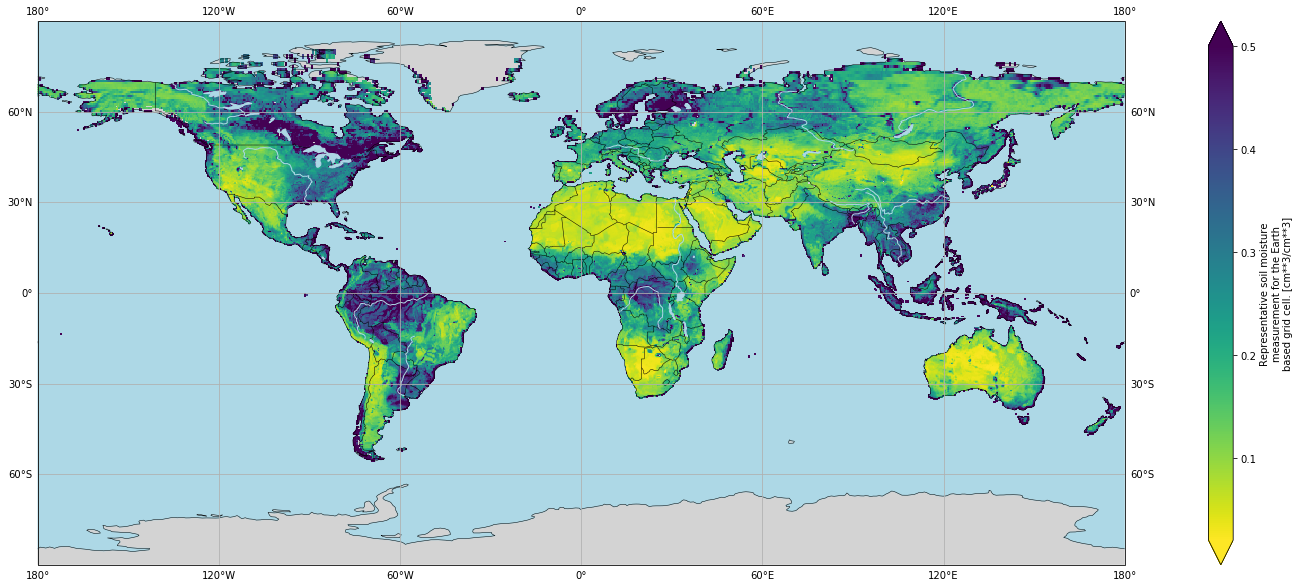

In [19]:
plot_data(sm_ts_mean)

In [20]:
n_lat = 55
w_lon = -135
s_lat = 15
e_lon = -55

conus_subset_coords = [w_lon, e_lon, n_lat, s_lat]

conus_subset_criteria = (EASE_LATS < n_lat) & (EASE_LATS > s_lat) & (EASE_LONS > w_lon) & (EASE_LONS < e_lon)

conus_subset = sm_timeseries.where(conus_subset_criteria)

/Users/brendanmcandrew/miniconda3/envs/smap-vis-env/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


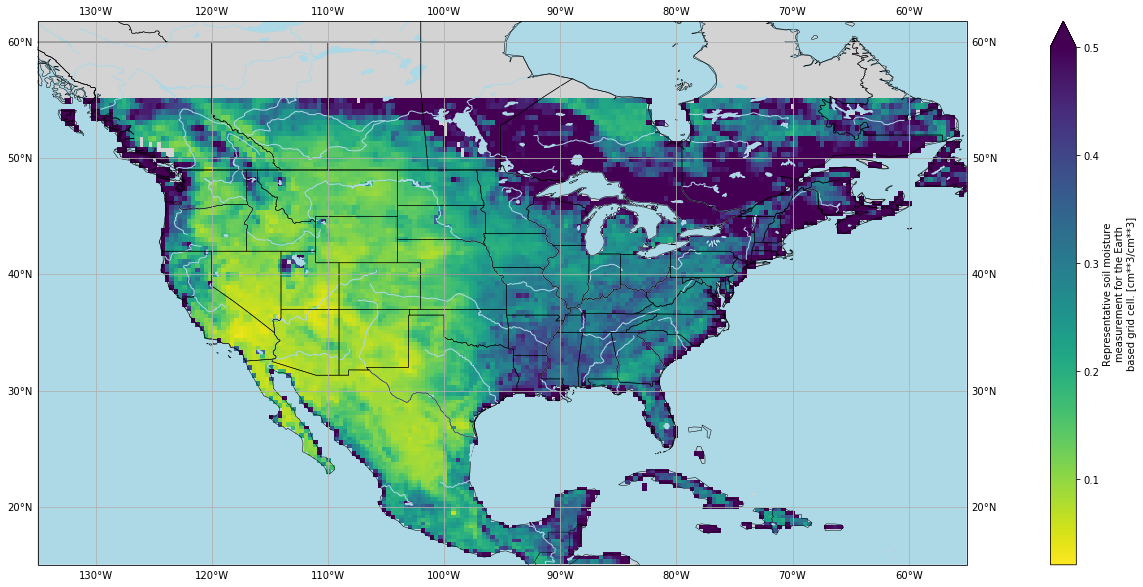

In [25]:
conus_sm_ts_mean = sm_ts_mean.where(conus_subset_criteria)
plot_data(conus_sm_ts_mean, extent=conus_subset_coords).add_feature(cartopy.feature.STATES, linewidth=0.5)

In [26]:
conus_mean_ts = conus_subset.mean(['y', 'x'])

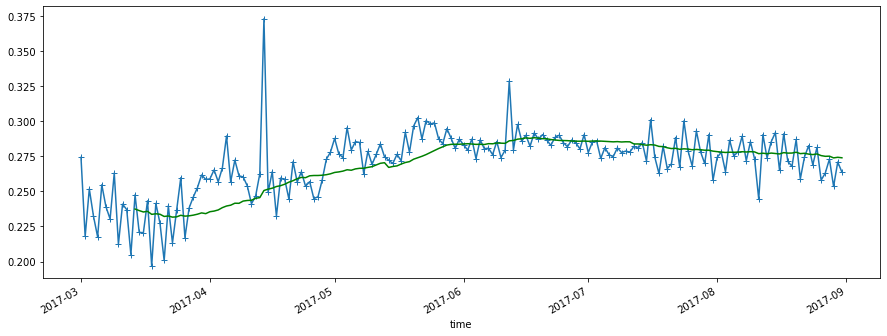

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
p = conus_mean_ts.plot(marker='+', ax=ax)

roll_window = '30D'
min_periods = 14

rolling_mean = conus_mean_ts.rolling(time=30, min_periods=min_periods).mean()
rolling_mean.plot(color='green', ax=ax)

In [28]:
midwest_site_lat, midwest_site_lon = 38, -99

In [32]:
 in EASE_LATS

False

In [42]:
n_lat = 40
w_lon = -103
s_lat = 35
e_lon = -96

midwest_subset_coords = [w_lon - 2, e_lon + 2, n_lat + 2, s_lat -2]

In [43]:
midwest_subset_criteria = (n_lat > EASE_LATS) & (s_lat < EASE_LATS) & (w_lon < EASE_LONS) & (e_lon > EASE_LONS)

midwest_subset = sm_timeseries.where(midwest_subset_criteria)

/Users/brendanmcandrew/miniconda3/envs/smap-vis-env/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


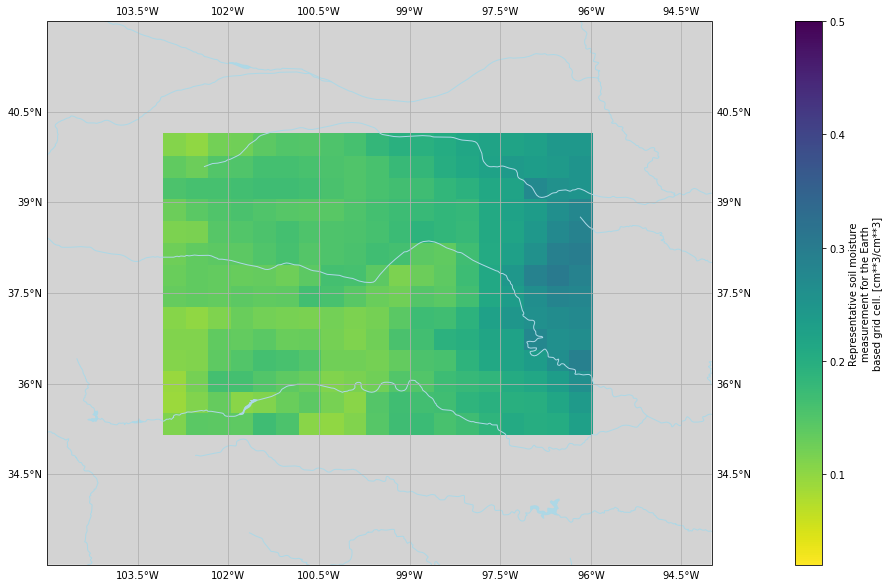

In [46]:
plot_data(calc_mean(midwest_subset), extent=midwest_subset_coords)

/Users/brendanmcandrew/miniconda3/envs/smap-vis-env/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


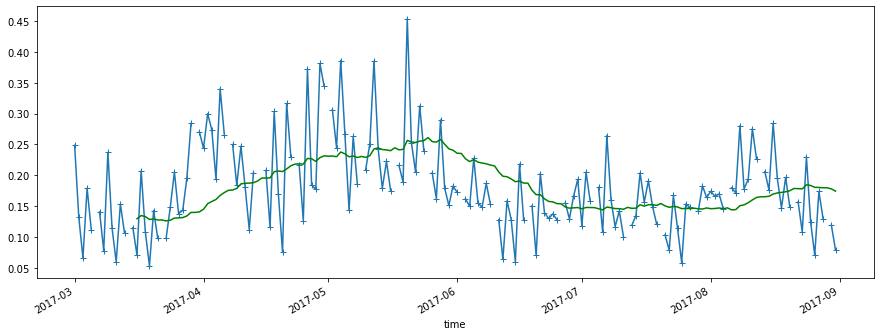

In [48]:
midwest_mean_ts = midwest_subset.mean(['y', 'x'])
fig, ax = plt.subplots(figsize=(15, 5))
p = midwest_mean_ts.plot(marker='+', ax=ax)

roll_window = '30D'
min_periods = 14

rolling_mean = midwest_mean_ts.rolling(time=30, min_periods=min_periods).mean()
rolling_mean.plot(color='green', ax=ax)